กลุ่ม pwf
นางสาว แพรวา เรืองศรี 660710250
นายศุกร์ภชัย ศิริอินภิบาล 660710256

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv('/content/cafethai_prices (1).csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [15]:
df.set_index('date', inplace=True)

In [16]:
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head()

,date,coffee_name,money
0,2023-03-01,Americano,1235
1,2023-03-01,Americano with Milk,1890
2,2023-03-01,Cappuccino,1800
3,2023-03-01,Cocoa,350
4,2023-03-01,Cortado,980


In [17]:
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
daily_item_counts.head()

,date,coffee_name,count
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14


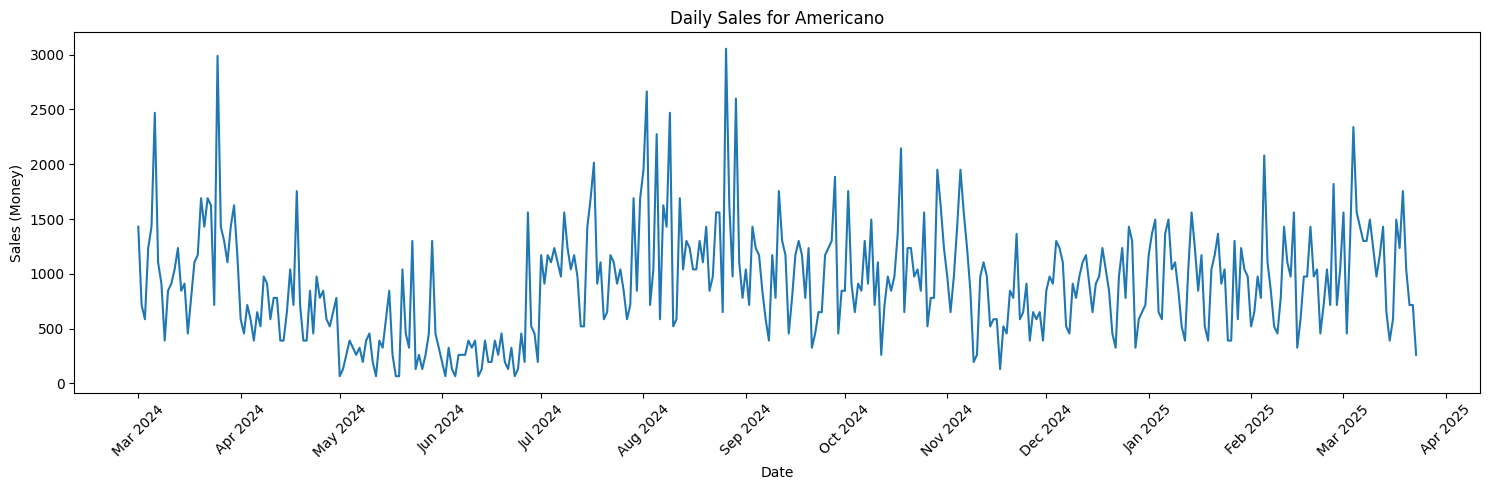

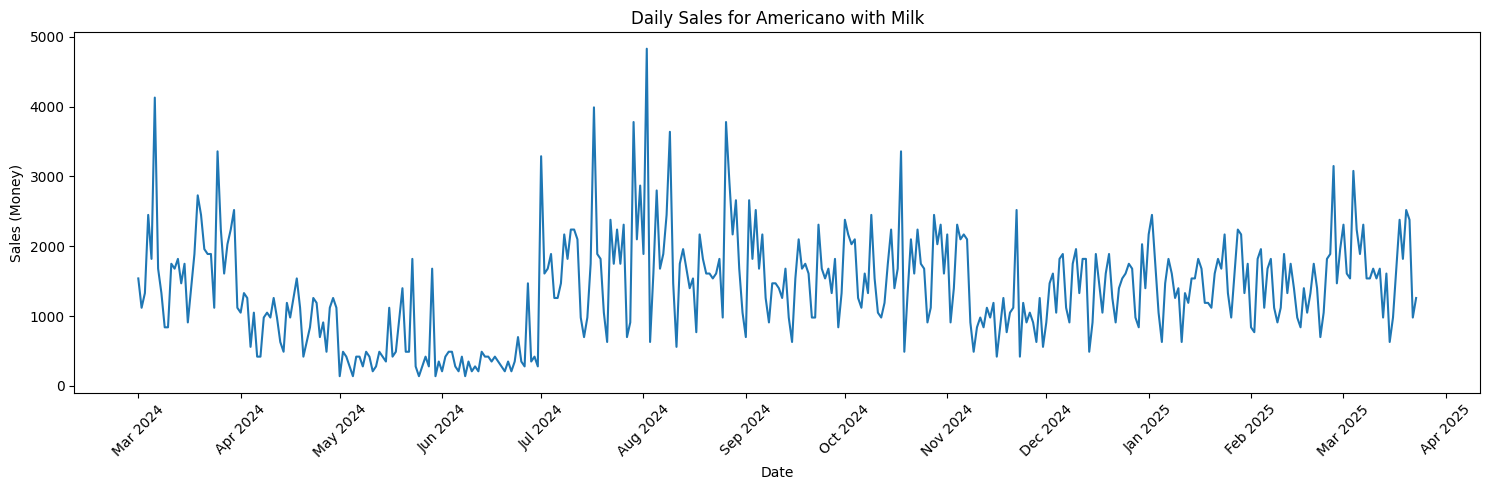

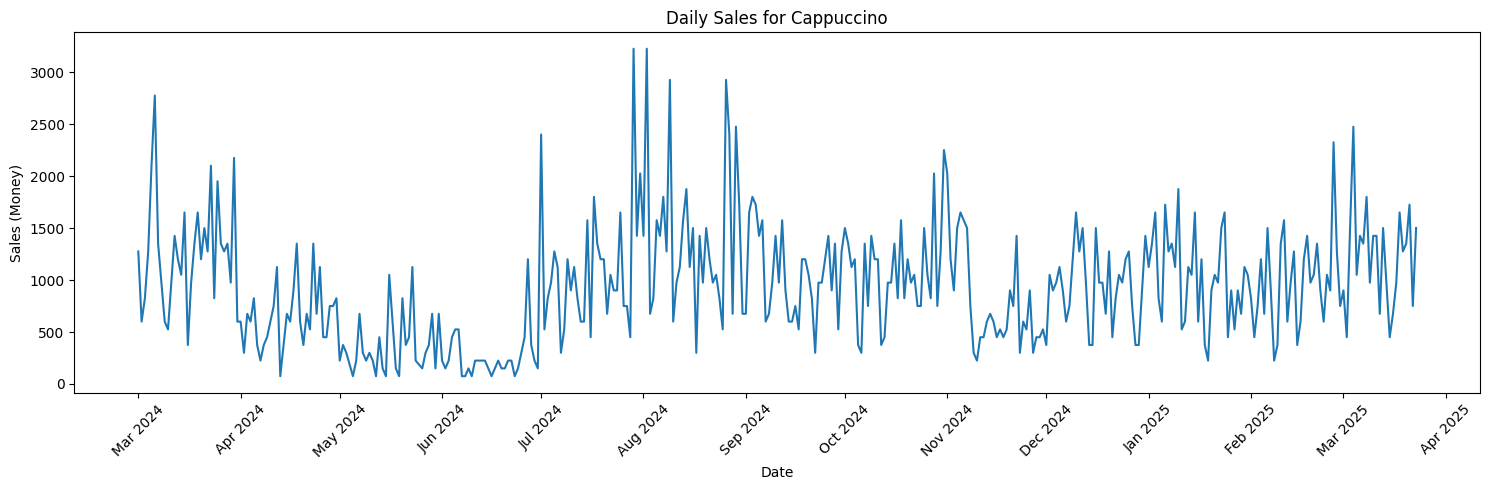

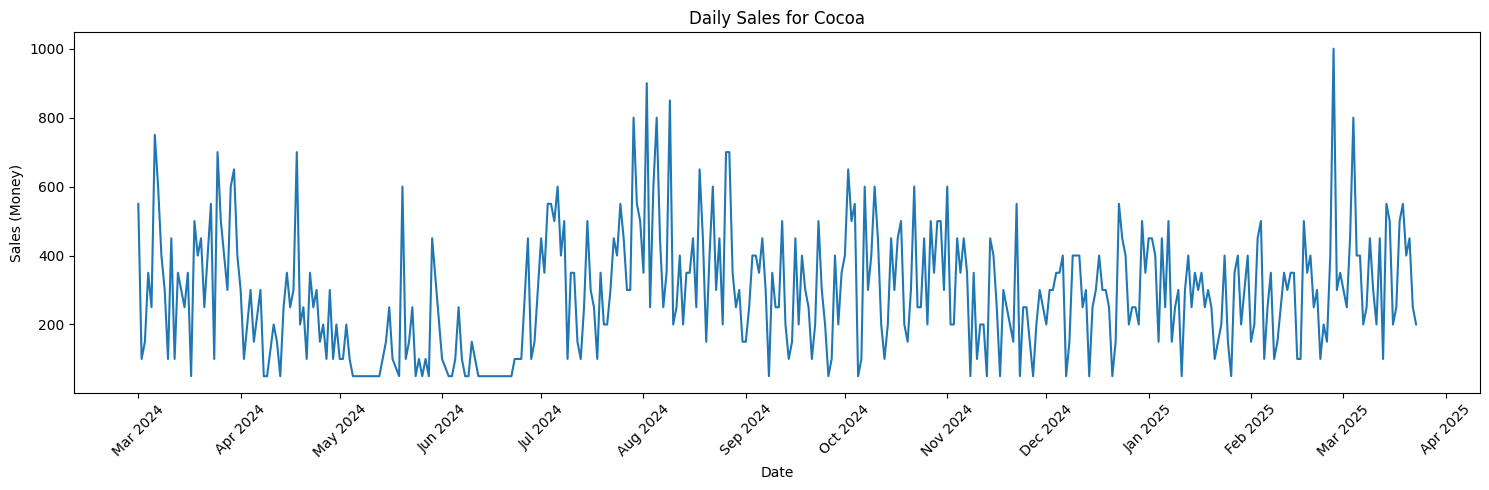

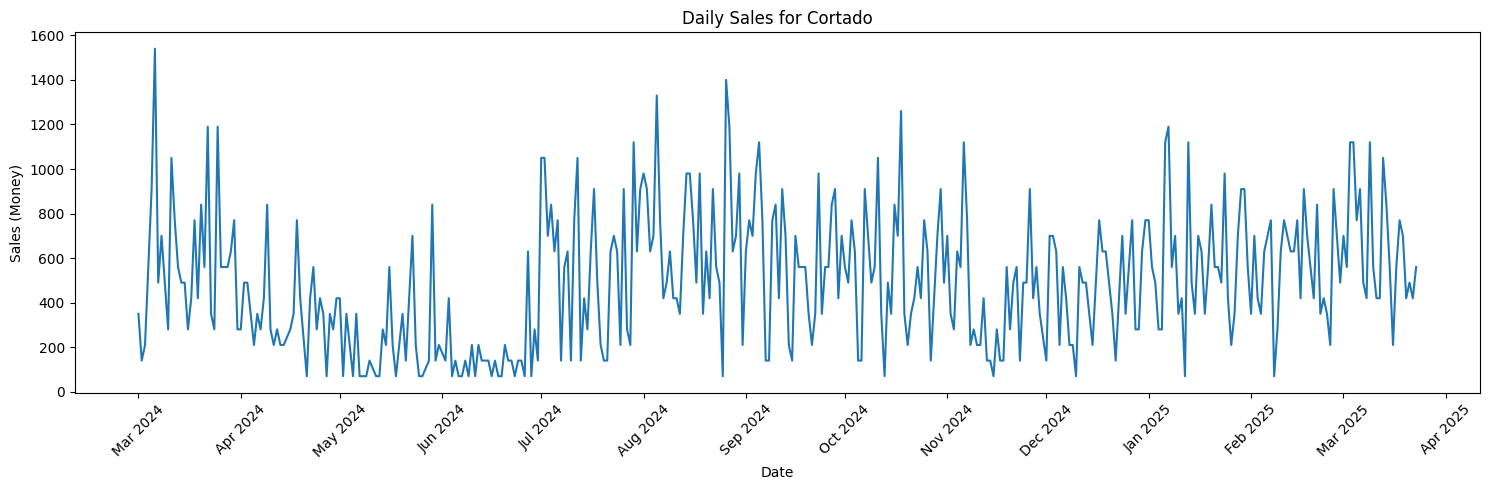

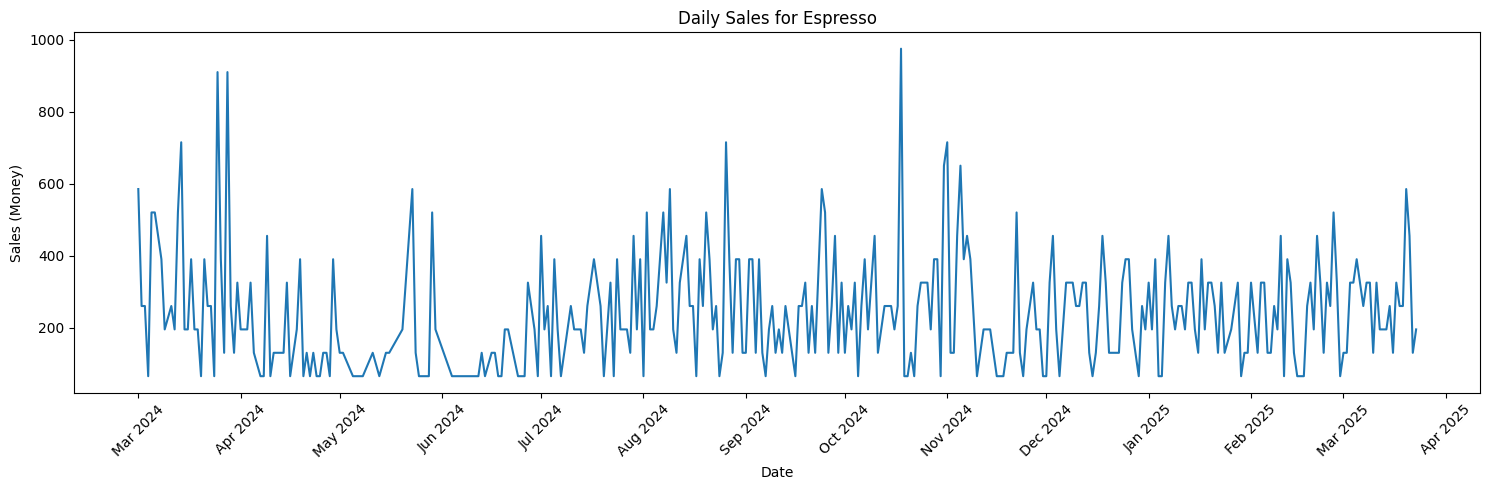

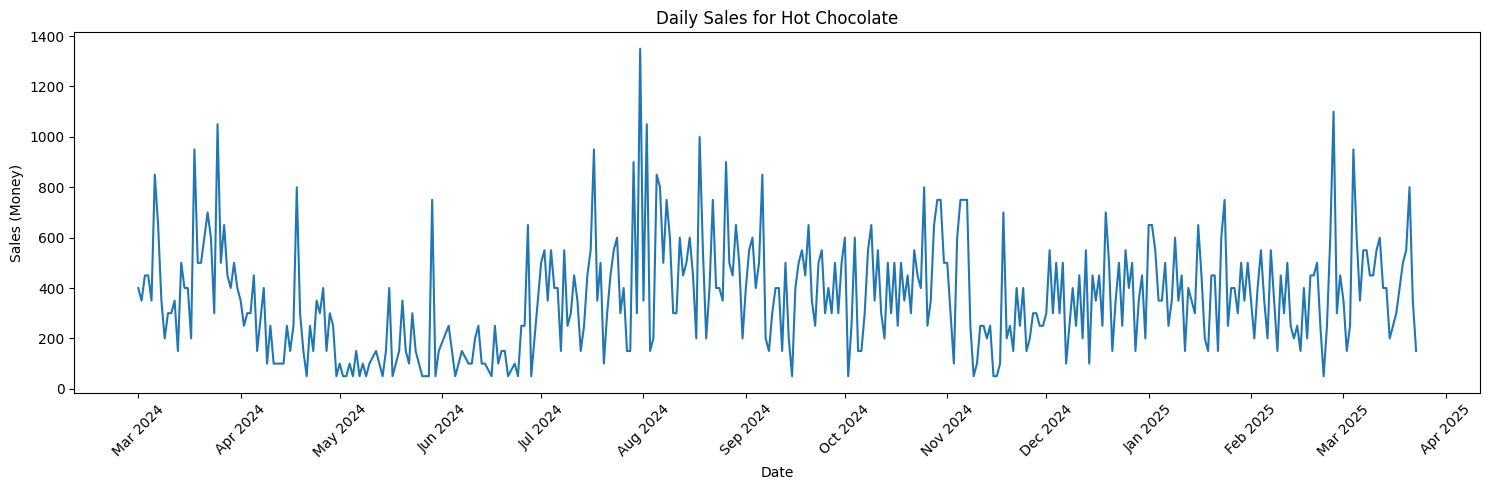

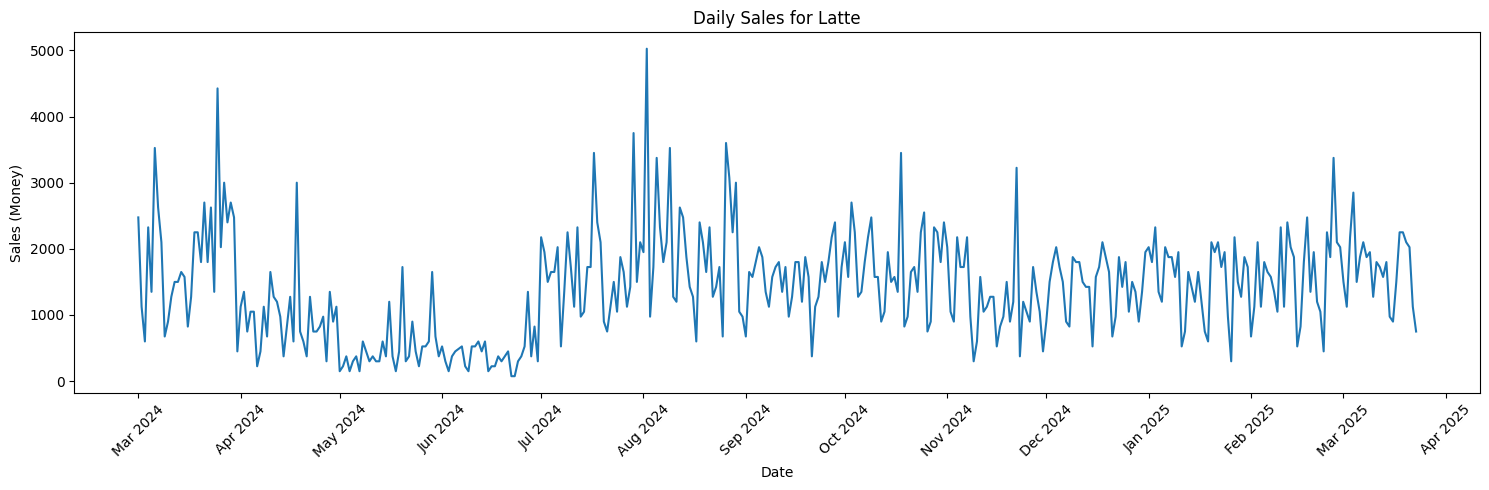

In [18]:
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True) # Set date as index for easier plotting
    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['money'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Ex.หาจำนวนแก้วทั้งหมดที่ขายได้แต่ละเมนู**

In [19]:
total = df.groupby('coffee_name').size().reset_index(name='total_sale')
print(total)

           coffee_name  total_sale
0            Americano       10822
1  Americano with Milk       15154
2           Cappuccino        9707
3                Cocoa        4455
4              Cortado        5427
5             Espresso        2626
6        Hot Chocolate        5380
7                Latte       14788


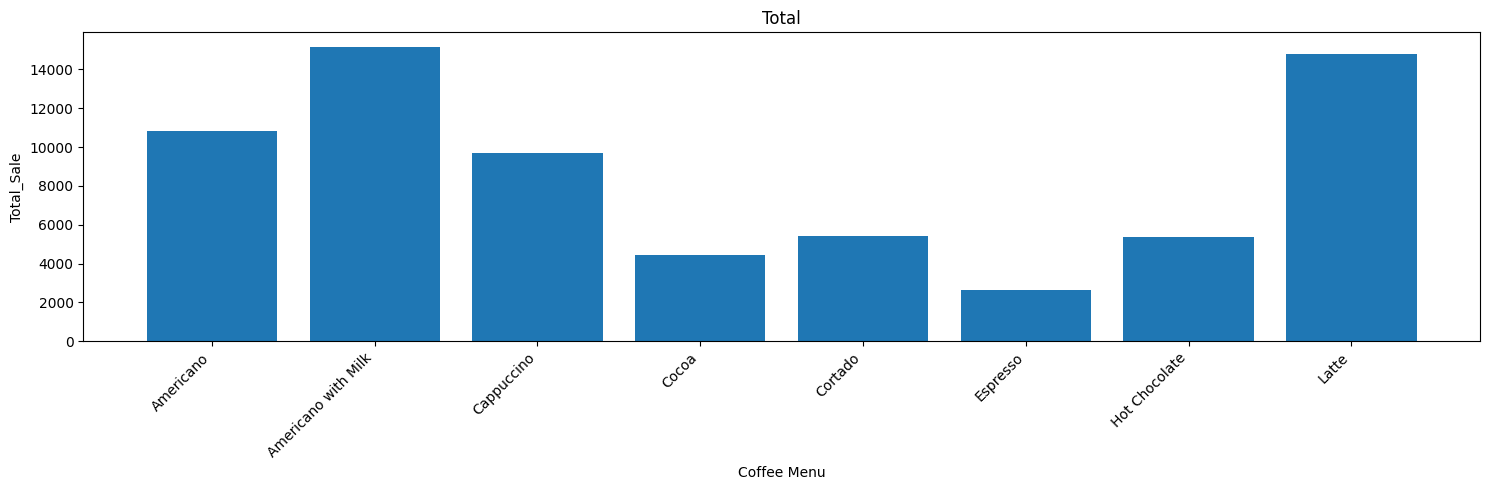

In [20]:
plt.figure(figsize=(15,5))
plt.bar(total['coffee_name'], total['total_sale'])
plt.xlabel("Coffee Menu")
plt.ylabel("Total_Sale")
plt.title("Total")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [21]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-m3qh5epk
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-m3qh5epk
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.3-py3-none-any.whl size=29457 sha256=1ed17963a7cb042bbb2bbd927e0f5c26133b09dc77300086832dedd8cf911cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-abpu6p9r/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [23]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [25]:
split_date = pd.to_datetime('2025-03-01')
daily_total_sales = daily_sales.groupby('date')['money'].sum().reset_index(name='total_sales')
historical_sales_before_split = daily_total_sales[daily_total_sales['date'] < split_date].copy()

context = torch.tensor(historical_sales_before_split['total_sales'].values)

prediction_length = 60
forecast = pipeline.predict(context, prediction_length)

median_prediction = forecast[0].median(dim=0).values
print(f"Chronos Median Forecast for the next {prediction_length} days:")
display(median_prediction)

Chronos Median Forecast for the next 60 days:


tensor([3678.0229, 3722.3364, 7045.8506, 7090.1641, 7001.5371, 7090.1641,
        7090.1641, 3456.4551, 3722.3364, 7045.8506, 7045.8506, 6912.9102,
        7045.8506, 7045.8506, 3766.6499, 3589.3960, 7090.1641, 7134.4785,
        7134.4785, 7045.8506, 7134.4785, 3766.6499, 3722.3364, 6912.9102,
        6912.9102, 7045.8506, 7090.1641, 6868.5967, 3633.7095, 3633.7095,
        6868.5967, 7001.5371, 6957.2236, 6912.9102, 6868.5967, 3545.0825,
        3500.7686, 6912.9102, 6912.9102, 6868.5967, 6868.5967, 6868.5967,
        3633.7095, 3456.4551, 6381.1484, 6779.9697, 6912.9102, 6779.9697,
        6824.2832, 3500.7686, 3500.7686, 4564.2935, 6735.6562, 6868.5967,
        6602.7158, 6735.6562, 3500.7686, 3412.1416, 4298.4126, 6691.3428])

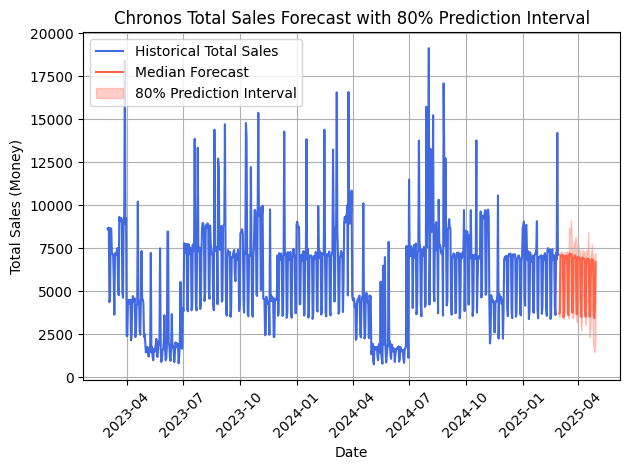

In [26]:
plt.plot(historical_sales_before_split['date'], historical_sales_before_split['total_sales'], color="royalblue", label="Historical Total Sales")
last_date_historical = historical_sales_before_split['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date_historical + pd.Timedelta(days=1), periods=prediction_length, freq='D')
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")


plt.title('Chronos Total Sales Forecast with 80% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Total Sales (Money)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
forecast[0][:][0]

tensor([7134.4785, 3234.8877, 3633.7095, 7045.8506, 6957.2236, 6868.5967,
        7045.8506, 7045.8506, 3456.4551, 3589.3960, 7090.1641, 6602.7158,
        7134.4785, 6824.2832, 7134.4785, 3545.0825, 3722.3364, 6868.5967,
        7001.5371, 6824.2832, 7045.8506, 6691.3428, 3500.7686, 4121.1582,
        6912.9102, 6868.5967, 6824.2832, 7134.4785, 6779.9697, 3412.1416,
        3678.0229, 6824.2832, 7090.1641, 7178.7920, 6868.5967, 4121.1582,
        3766.6499, 3545.0825, 7134.4785, 9616.0361, 6912.9102, 6868.5967,
        7267.4189, 3412.1416, 3367.8281, 6868.5967, 7045.8506, 6868.5967,
        6868.5967, 6912.9102, 3500.7686, 3722.3364, 6868.5967, 7001.5371,
        6824.2832, 6691.3428, 6868.5967, 3234.8877, 3456.4551, 6691.3428])

In [29]:
median_forecast = np.median(forecast[0], axis=0)

print("ค่ามัธยฐานของผลการพยากรณ์ 2 เดือนข้างหน้า")
print(median_forecast)

ค่ามัธยฐานของผลการพยากรณ์ 2 เดือนข้างหน้า
[3700.1797 3722.3364 7068.0073 7090.164  7023.694  7112.3213 7090.164
 3478.6118 3744.4932 7045.8506 7045.8506 6912.91   7045.8506 7068.0073
 3810.9634 3611.5527 7090.164  7200.9487 7134.4785 7090.1646 7156.6353
 3788.8066 3744.4932 6935.067  6912.91   7045.8506 7090.164  6935.067
 3678.023  3655.8662 6957.2236 7001.537  6979.3804 6912.91   6868.5967
 3545.0825 3500.7686 6935.067  6957.2236 6868.5967 6890.7534 6890.7534
 3700.1797 3522.9255 6558.4023 6824.283  6912.91   6802.1265 6846.44
 3522.9255 3522.9255 5627.8184 6802.1265 6868.5967 6669.186  6802.1265
 3567.239  3434.2983 4342.726  6691.343 ]
